### Основные понятия в глубоком обучении

__Нейронная сеть (neural network)__ – композиция линейных и нелинейных преобразований. В целом, нейронная сеть представляет собой сложную (параметрическую) функцию $f$, задающую отображение из исходного признакового пространства $\mathbb{X}_O$ в целевое пространство $\mathbb{Y}$:
$$
f: \;\;\; \mathbb{X}_O \longrightarrow \mathbb{Y}.
$$
Часто нейронные сети представляют собой последовательность преобразований, представленных слоями и функциями активации.

__Слой (layer)__ – некоторая функция/преобразование над исходными данными. Простейший пример: линейный слой, являющийся линейным преобразованием над входящими данными (т.е. просто преобразование $WX +b$, как и в линейной регрессии).

__Функция активации (activation function)__ – нелинейное преобразование, применяющееся ко всем данным пришедшим на вход поэлементно. Благодаря функциям активации нейронные сети способны преобразовывать данные *нелинейным образом*, что позволяет порождать более информативные признаковые описания.

__Функция потерь (loss function)__ – функция потерь, оценивающая качество полученного предсказания. Как правило, от функции потерь требуется свойство дифференцируемости.

### Интерактивная демонстрация работы нейронных сетей
Воспользуемся замечательной интерактивной "песочницей": https://playground.tensorflow.org/ для демонстрации процессов, происходящих "внутри" нейронной сети.

### (Почти) реальная задача: 
В заключение, обратимся к задаче распознавания рукописных цифр. Для этого воспользуемся классическим набором данных [MNIST](http://yann.lecun.com/exdb/mnist/), который содержит около 60 тысяч изображений из десяти классов.

Классификация датасета MNIST является некоторым "Hello world" в мире глубокого обучения и компьютерного зрения в частности. 

Конечно, в настоящий момент подобный набор данных выглядит "игрушечным" (как с точки зрения его размеров, так и с точки зрения самой структуры изображений). В научной среде уже не раз упоминалась его излишне простая структура, но своей наглядности и истории он от этого не теряет.

Загрузка и предобработка данных практически полностью сделана за нас.

In [79]:
import torch
import torchvision
from torch import nn
import numpy as np
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [80]:
train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

In [81]:
print(f'train dataset size: {len(train_mnist_data)}\ntest dataset size: {len(test_mnist_data)}')

train dataset size: 60000
test dataset size: 10000


В обучающей выборке `train_mnist_data` содержатся $60000$ примеров, на которые мы будем настраивать параметры нашей модели. Тестовая выборка `test_mnist_data` (содержит $10000$ примеров) будет использоваться для оценки качества итоговой модели.

Рассмотрим данные внимательно:

Text(0.5, 1.0, 'Image label: 0')

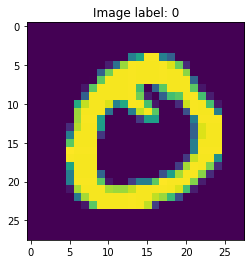

In [83]:
random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')


Также, напоминю, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Построим простую нейронную сеть, представляющую собой один линейный слой (и подходящую функцию активации – softmax). По сути, эта модель аналогична логистической регрессии. На вход будем подавать 784 признака, т.е. значение каждого пикселя изображения. Предсказывать будем ненормированные вероятности для каждого класса (т.е. 10 чисел).

In [88]:
# Creating model instance
model = nn.Sequential()

# Linear layer mapping 784 features (28*28 pixels) to 10 target values
model.add_module('l1', nn.Linear(784, 10))

Не удивляйтесь явному отсутствию функции активации в конце, она появится позднее. В итоге у нашей модели $7850$ параметров:

In [89]:
print("Weight shapes:", [w.shape for w in model.parameters()])

Weight shapes: [torch.Size([10, 784]), torch.Size([10])]


Проверим поведение модели на случаных данных подходящей размерности и типа:


In [90]:
# create dummy data with 32 (`batch_size`) samples and 784 features
x = random_batch[0].reshape(-1, 784)
y = random_batch[1]

# compute outputs given inputs, both are variables
y_predicted = model(x)


В качестве функции ошибки воспользуемся перекрестной энтропией (или кроссэнтропией, как ее принято называть). Она оценивает, насколько предсказанные вероятности принадлежности к тому или иному классу соответствуют истинным (100% верному классу, 0% всем остальным).

Стоит обратить внимание, что `nn.CrossEntropyLos` уже включает в себя функцию активации (`LogSoftMax`). Именно поэтому мы не стали указывать функцию активации явно при построении самой сети. Т.к. нейронная сеть и функция потерь представляют собой единый граф вычислений, это абсолютно корректно и, вдобавок, удобно.

In [91]:
loss_function = nn.CrossEntropyLoss()
loss = loss_function(y_predicted, y)

Значение функции ошибки получилось следующим. Нельзя сказать, что оно слишком информативно.

In [92]:
loss

tensor(2.3238, grad_fn=<NllLossBackward0>)

PyTorch позволяет автоматически вычислять градиенты для моделей (и вообще математических выражений) которые удовлетворяют простым ограничениям. Обратим внимание на то, что значение градиентов для градиентного спуска могут быть оценены используя модуль `opt`. Воспользуемся самым простым оптимизатором -  SGD:

In [93]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

# Get the gradients
loss.backward()   

# Make a step
opt.step()           

# Remove the gradients from the previous step
opt.zero_grad()

Одна эпоха обучения включает в себя количество шагов, необходимых для покрытия (примерно) всего датасета.

In [94]:
NUM_EPOCHS = 5
history = []
plot_history = []

for epoch in range(NUM_EPOCHS):
    for _i, batch in enumerate(train_data_loader):
        x_batch, y_batch = batch

        # Get logit predictions
        y_predicted = model(x_batch.reshape(-1, 784))

        # Compute loss
        loss = loss_function(y_predicted, y_batch)

        # Get gradients
        loss.backward()

        # Make a gradient update
        opt.step()

        # Remove the gradients from the previous step
        opt.zero_grad()

        history.append(loss.item())

Оценим качество нашей модели на тестовой (или же отложенной) выборке. Для этого подсчитаем количество правильно классифицированных цифр.


In [95]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [96]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.9082


### Метод обратного распространения ошибки и автоматическое вычисление градиентов в PyTorch

Как уже не раз упоминалось, PyTorch позволяет автоматически вычислять градиенты.  Каждый "тензор" в PyTorch обладает булевым свойством `requires_grad`. Если ему присвоено значение `True`, то по данному тензору может быть посчитан градиент.

Общая процедура выглядит следующим образом:
* Пусть `x = torch.arange(5, requires_grad=True)`.
* Результат операции суммирования будет равен `b = torch.sum(x)`.
* Для вычисления градиентов достаточно вызвать метод `b.backward()` у результата операции суммирования.
* После этого у `x` появятся градиенты $\frac{\delta b}{\delta x}$.

Также стоит помнить, что если `x` одновременно участвует в нескольких операциях, то градиенты от них __суммируются__.


Рассмотрим на интерактивном примере:

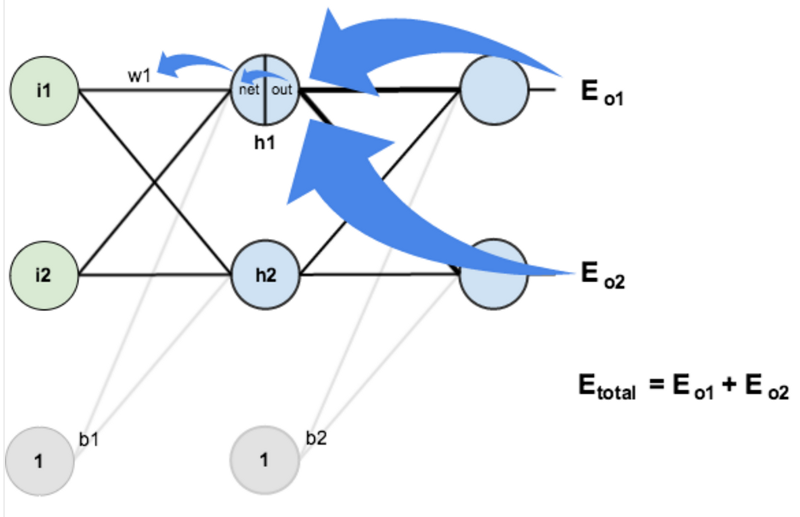

#### Упрощенная задача оценки стоимости жилья
Воспользуемся рассмотренными методами для решения задачи оценки стоимости жилья с использованием набора данных _Boston house-prices dataset_. Для начала рассмотрим одномерный случай.

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

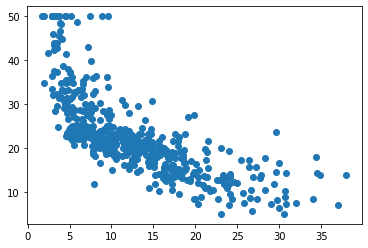

In [97]:
from sklearn.datasets import load_boston
boston = load_boston()
plt.scatter(boston.data[:, -1], boston.target)

In [103]:
boston

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
         4.9800e+00],
        [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
         9.1400e+00],
        [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
         4.0300e+00],
        ...,
        [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         5.6400e+00],
        [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
         6.4800e+00],
        [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
         7.8800e+00]]),
 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
        18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
        15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
        13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
        21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
        35.4, 24.7, 3

In [98]:
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

x = torch.tensor(boston.data[:,-1] / 10, dtype=torch.float32)
y = torch.tensor(boston.target, dtype=torch.float32)

In [99]:
y_pred = w * x + b
loss = torch.mean( (y_pred - y)**2 )

# propagete gradients
loss.backward()

Градиенты можно увидеть в поле `.grad` у всех переменных, которые их "требуют".

In [100]:
print("dL/dw = {}\n".format(w.grad))
print("dL/db = {}\n".format(b.grad))

dL/dw = tensor([-47.3514])

dL/db = tensor([-45.0656])



Ввиду накопления градиентов по умолчанию, __очищать их между шагами градиентного спуска необходимо вручную__.

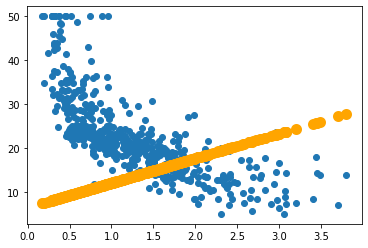

loss =  235.74483


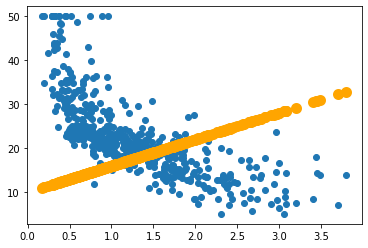

loss =  186.47456


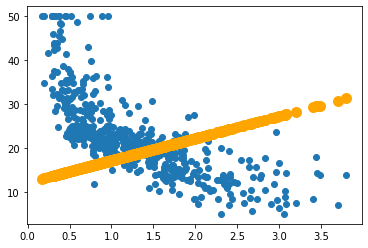

loss =  162.19214


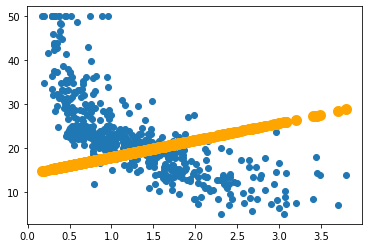

loss =  142.33264


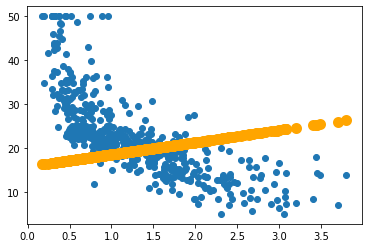

loss =  125.67492


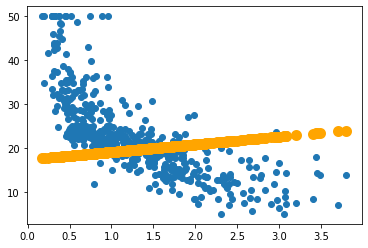

loss =  111.68952


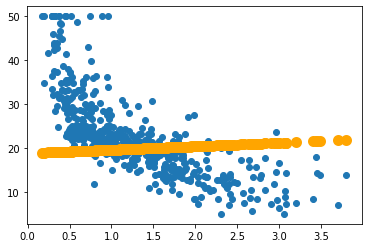

loss =  99.94737


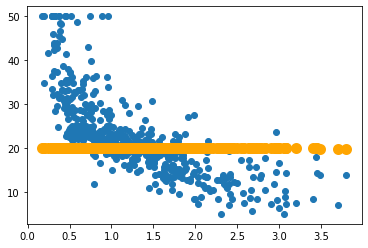

loss =  90.08865


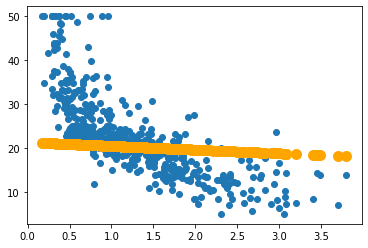

loss =  81.81123


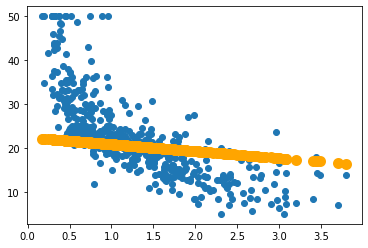

loss =  74.86148


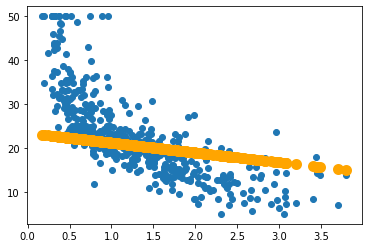

loss =  69.02647


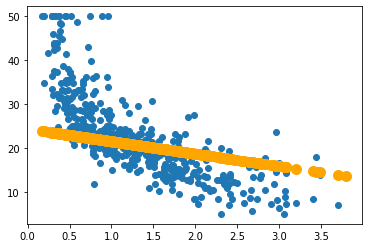

loss =  64.127365


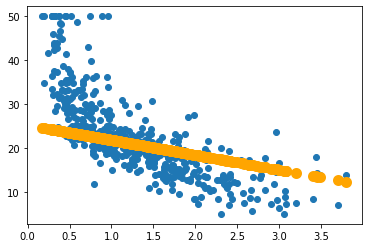

loss =  60.014065


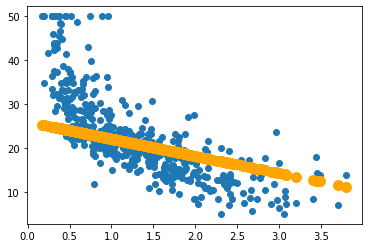

loss =  56.56053


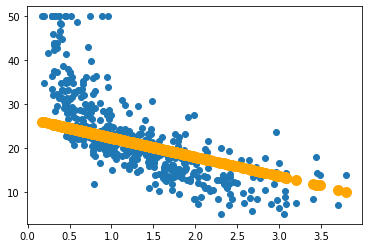

loss =  53.66094


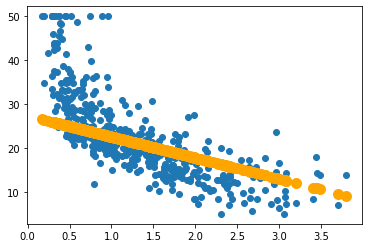

loss =  51.226433


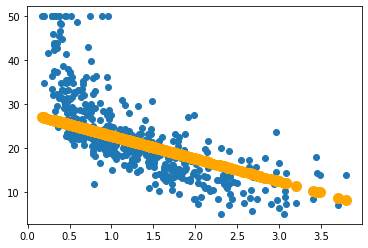

loss =  49.182404


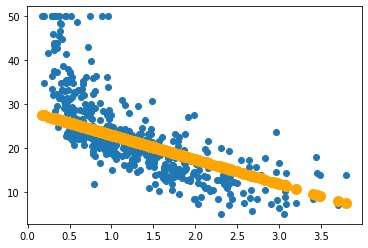

loss =  47.466232


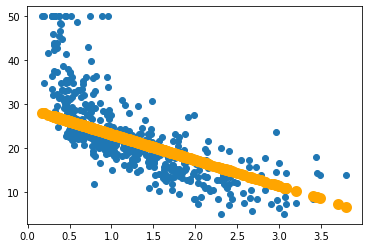

loss =  46.02535


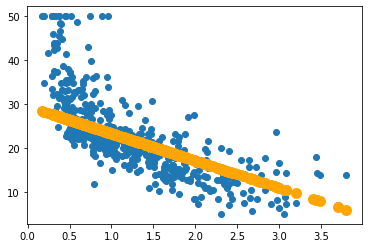

loss =  44.815567


In [107]:
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

x = torch.tensor(boston.data[:,-1] / 10, dtype=torch.float32)
y = torch.tensor(boston.target, dtype=torch.float32)

for i in range(100):

    y_pred = w * x + b
    loss = torch.mean( (y_pred - y)**2 ) #mse calculation
    loss.backward() #gradients for w and B

    w.data -= 0.05 * w.grad.data
    b.data -= 0.05 * b.grad.data
    
    #zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    # the rest of code is just bells and whistles
    if (i+1)%5==0:
        #clear_output(True)
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.scatter(x.data.numpy(), y_pred.data.numpy(), color='orange', linewidth=5)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.05:
            print("Done!")
            break

Полезно обратить внимание на один небольшой, но очень важный момент: все значения тензора `x` были поделены на "волшебную" константу 10. Посмотрим, что произойдет, если этого не делать:

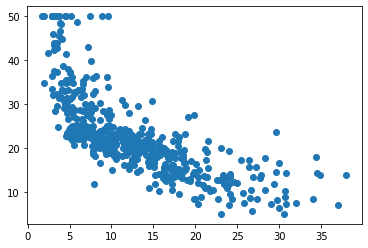

loss =  nan


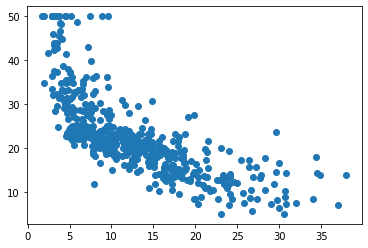

loss =  nan


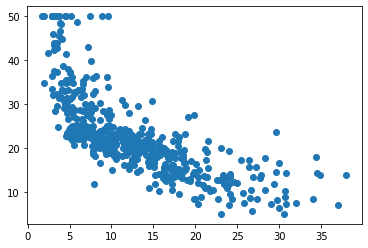

loss =  nan


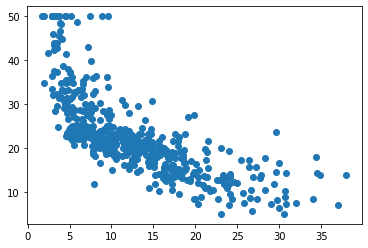

loss =  nan


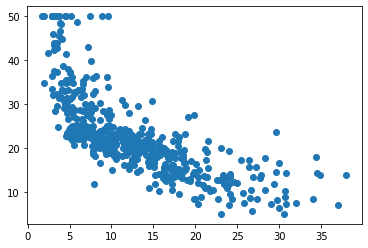

loss =  nan


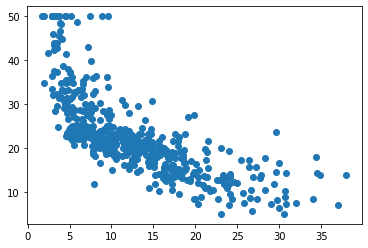

loss =  nan


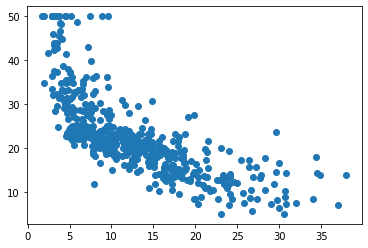

loss =  nan


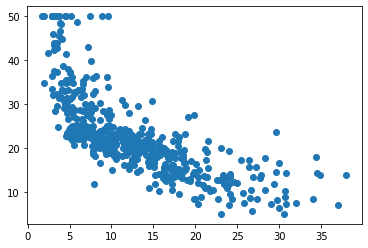

loss =  nan


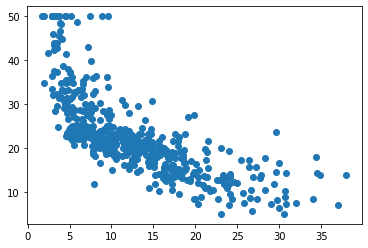

loss =  nan


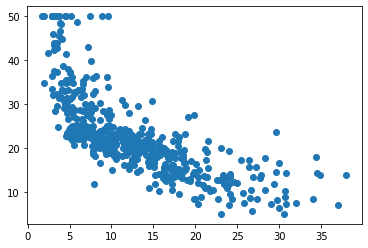

loss =  nan


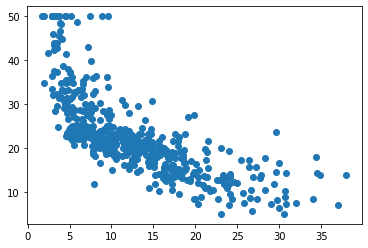

loss =  nan


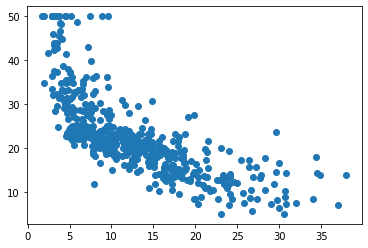

loss =  nan


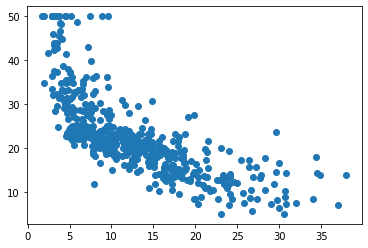

loss =  nan


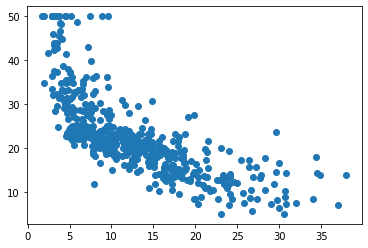

loss =  nan


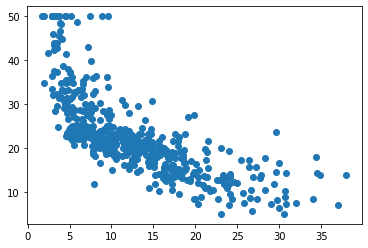

loss =  nan


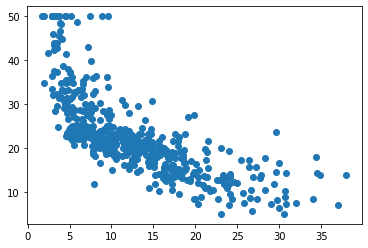

loss =  nan


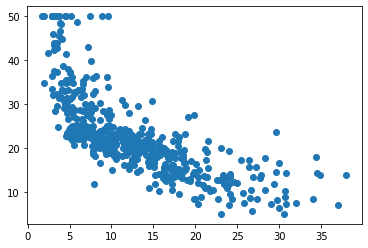

loss =  nan


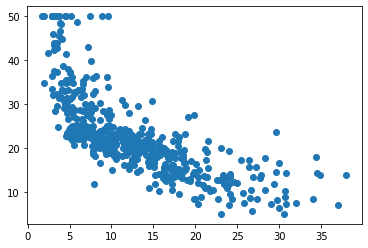

loss =  nan


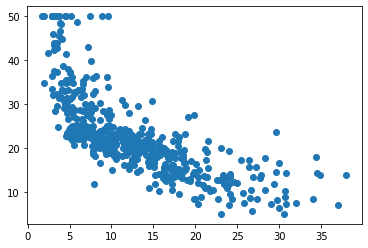

loss =  nan


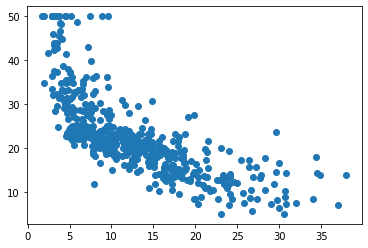

loss =  nan


In [106]:
# Now we do not divide the x values by 10. See what happens next
x = torch.tensor(boston.data[:,-1], dtype=torch.float32)

grad_history = []

for i in range(100):

    y_pred = w * x  + b
    loss = torch.mean( (y_pred - y)**2 )
    loss.backward()
    grad_history.append((w.grad.item(), b.grad.item()))

    # Be extremely careful with accessing the .data attribute!
    w.data -= 0.05 * w.grad.data
    b.data -= 0.05 * b.grad.data
    
    #zero gradients
    w.grad.data.zero_()
    b.grad.data.zero_()
    
    # the rest of code is just bells and whistles
    if (i+1)%5==0:
        #clear_output(True)
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.scatter(x.data.numpy(), y_pred.data.numpy(), color='orange', linewidth=5)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.05:
            print("Done!")
            break


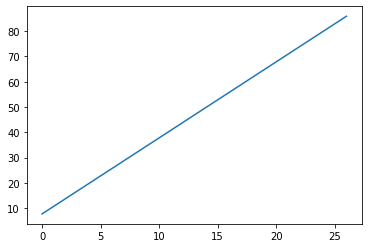

In [105]:
plt.plot([np.log(np.abs(element[0])) for element in grad_history], )

In [39]:
print(grad_history)

[(7899419648.0, 474259232.0), (-159373672448.0, -9568352256.0), (3215422390272.0, 193045004288.0), (-64872326889472.0, -3894754410496.0), (1308822832414720.0, 78578096013312.0), (-2.640597647936717e+16, -1585341551083520.0), (5.327502172970025e+17, 3.1984842644127744e+16), (-1.0748429848952177e+19, -6.453059169623736e+17), (2.1685349416058644e+20, 1.3019279801100272e+19), (-4.3750987006777103e+21, -2.6266875390731485e+20), (8.826921963097202e+22, 5.299438598822484e+21), (-1.78086366085548e+24, -1.0691811227755572e+23), (3.5929574288434494e+25, 2.1571118116637684e+24), (-7.248923309185748e+26, -4.352051784938741e+25), (1.462496829687177e+28, 8.780424390938284e+26), (-2.9506407372954892e+29, -1.7714826853712827e+28), (5.953025161943487e+30, 3.574031269755464e+29), (-1.201044687125463e+32, -7.210738391934484e+30), (2.423151415279944e+33, 1.4547928973889674e+32), (-4.888796546039404e+34, -2.9350973404787804e+33), (9.863326282876306e+35, 5.921667361233019e+34), (-1.9899622222503153e+37, -1.

Как вы могли заметить, мы столкнулись с "взрывом градиентов" (exloding gradients). Данная проблема является достаточно частой, и для ее решения используется нормировка данных, понижение learning rate или же техника _gradient clipping_, которая будет рассмотрена позднее.

Константа 10 в данном случае была подобрана вручную. Лучше пользоваться классическими методами нормировки.

### Оптимизаторы
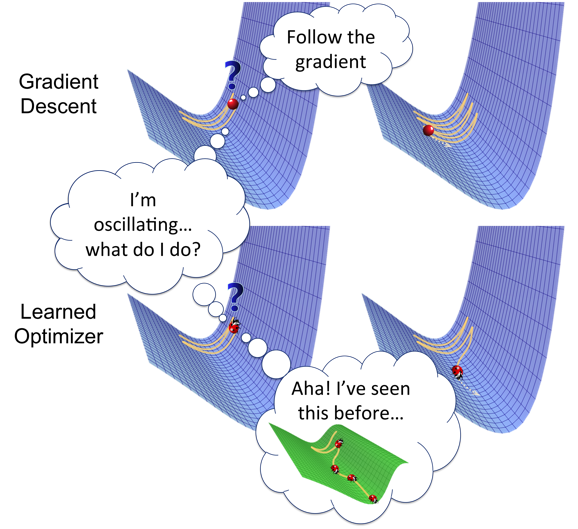
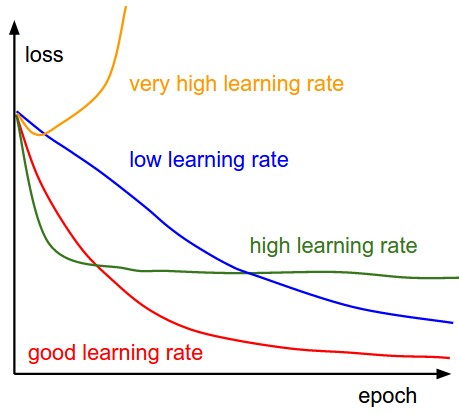

Наиболее часто используются следующие оптимизаторы:

- SGD
- Momentum
- Adagrad
- RMSprop
- Adam

#### Стохастический градиентный спуск (SGD)

В ходе работы алгоритм обновляет параметры в отрицательном направлении градиента. Параметр скорости обучения $\epsilon_k$ должен уменьшаться со временем. Время вычислений SGD пропорционально размеру мини-партии $m$:

\begin{eqnarray}
g &=& \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\theta), y^{(i)}) \\
\theta &=& \theta - \epsilon_k \times g
\end{eqnarray}


#### Momentum

Момент накапливает экспоненциально убывающее скользящее среднее прошлых градиентов и продолжает двигаться в их направлении, поэтому размер шага зависит от того, насколько велика и насколько выровнена последовательность градиентов, обычные значения параметра импульса 𝛼 0,5 и 0,9:

\begin{eqnarray}
v &=& \alpha v - \epsilon \nabla_\theta \big(\frac{1}{m}\sum_i 
L(f(x^{(i)};\theta), y^{(i)}) \big) \\
\theta &=& \theta + v
\end{eqnarray}

#### Adagrad

**AdaGrad** адаптирует скорость обучения всех параметров модели, скорость обучения обратно пропорциональна квадратному корню из суммы исторических квадратов, веса, которые получают высокие градиенты, уменьшают свою эффективную скорость обучения, а веса, которые получают небольшие или редкие обновления, увеличивают свою эффективную скорость обучения: чистый эффект - больший прогресс в более пологих направлениях пространства параметров:

\begin{eqnarray}
g &=& \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\theta), y^{(i)}) \\
s &=& s + g^{T}g \\
\theta &=& \theta - \epsilon_k \times g / \sqrt{s+eps}
\end{eqnarray}

#### RMSprop
**RMSProp** модифицирует AdaGrad, изменяя накопление градиента на экспоненциально взвешенное скользящее среднее, он отбрасывает историю из ближайших эпох. RMSProp был показан как эффективный и практичный алгоритм оптимизации для глубоких нейронных сетей:

\begin{eqnarray}
g &=& \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\theta), y^{(i)}) \\
s &=& \mathrm{decay\_rate}\times s + (1-\mathrm{decay\_rate}) g^{T}g \\
\theta &=& \theta - \epsilon_k \times g / \sqrt{s+eps}
\end{eqnarray}

#### Adam
**Adam** происходит от "adaptive moments", его можно рассматривать как вариант комбинации RMSProp и momentum, обновление выглядит как RMSProp, за исключением того, что используется гладкая версия градиента вместо необработанного стохастического градиента, полное обновление adam также включает механизм коррекции смещения, рекомендуемые значения в статьях: $\epsilon = 1e-8$, $\beta_1 = 0.9$, $\beta_2 = 0.999$:

\begin{eqnarray}
g &=& \frac{1}{m}\nabla_\theta \sum_i L(f(x^{(i)};\theta), y^{(i)}) \\
m &=& \beta_1 m + (1-\beta_1) g\\
s &=& \beta_2 v + (1-\beta_2) g^{T}g \\
\theta &=& \theta - \epsilon_k \times m / \sqrt{s+eps}
\end{eqnarray}

Хорошая [теория](https://ruder.io/optimizing-gradient-descent/index.html) по различным алгоритмам

<img src="opt2.gif" width="750" align="center">

<img src="opt1.gif" width="750" align="center">

### Простой синтаксис для демонстрации запуска оптимизатора

In [78]:
import torch.optim as optim
from torch.autograd import Variable

# Let's make some data for a linear regression.
A = 5.1213945
b = 3.2047893
error = 0.1
N = 100 # number of data points

# Data
X = Variable(torch.randn(N, 1))

# (noisy) Target values that we want to learn.
t = A * X + b + Variable(torch.randn(N, 1) * error)


# Creating a model, making the optimizer, defining loss
model = nn.Linear(1, 1)
optimizer = optim.Adam(model.parameters(), lr=0.05)
loss_fn = nn.MSELoss()

# Run training
niter = 10
for _ in range(0, niter):
    optimizer.zero_grad()
    predictions = model(X)
    loss = loss_fn(predictions, t)
    loss.backward()
    optimizer.step()

    print("-" * 10)
    print("learned A = {}".format(list(model.parameters())[0].data[0, 0]))
    print("learned b = {}".format(list(model.parameters())[1].data[0]))

----------
learned A = 0.6149395108222961
learned b = 1.0400190353393555
----------
learned A = 0.6648980379104614
learned b = 1.0900084972381592
----------
learned A = 0.7147859334945679
learned b = 1.1399803161621094
----------
learned A = 0.7645727396011353
learned b = 1.1899272203445435
----------
learned A = 0.8142269849777222
learned b = 1.239842176437378
----------
learned A = 0.8637160658836365
learned b = 1.2897179126739502
----------
learned A = 0.9130063652992249
learned b = 1.3395472764968872
----------
learned A = 0.9620633125305176
learned b = 1.3893229961395264
----------
learned A = 1.0108513832092285
learned b = 1.4390380382537842
----------
learned A = 1.0593342781066895
learned b = 1.4886852502822876


In [49]:
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [50]:
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)

y_train_torch = torch.tensor(y_train, dtype=torch.float32)[:, None]
y_test_torch = torch.tensor(y_test, dtype=torch.float32)[:, None]

In [52]:
boston.data.shape

(506, 13)

In [57]:
NUM_FEATURES = X_train.shape[1]

In [58]:
# Creating model instance
model = nn.Sequential()

model.add_module('l1', nn.Linear(NUM_FEATURES, 1))

На текущий момент в нашей модели лишь один слой:

In [59]:
print("Weight shapes:", [w.shape for w in model.parameters()])

Weight shapes: [torch.Size([1, 13]), torch.Size([1])]


Рассмотрим поведение нашей модели на данных подходящей размерности:


In [60]:
example_input = X_train_torch[:3]
example_target = y_train_torch[:3]

# compute outputs given inputs, both are variables
y_predicted = model(example_input)

y_predicted # display what we've got

tensor([[-0.4364],
        [ 0.3497],
        [-0.3865]], grad_fn=<AddmmBackward0>)

В качестве функции потерь воспользуемся среднеквадратичной ошибкой MSE. Она также уже реализована в виде класса в PyTorch: `nn.MSELoss` (или в виде функции `F.mse_loss`).

In [61]:
loss_function = nn.MSELoss()
loss = loss_function(y_predicted, example_target)

Теперь мы сможем вычислить градиенты простым вызовом `loss.backward()`. Но перед этим введем последнее улучшение в базовый pipeline для одномерного случая. В нем мы реализовывали градиентный спуск вручную. Конечно, на практике используются уже реализованные механизмы оптимизации, такие как `SGD, Momentum, RMSProp, Adam` и другие. Они доступны в `torch.opt`.

In [62]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

# Get the gradients
loss.backward()   

# Make a step
opt.step()           

# Remove the gradients from the previous step
opt.zero_grad()

In [63]:
# Creating model instance
model = nn.Sequential()

model.add_module('l1', nn.Linear(NUM_FEATURES, 16))
model.add_module('relu', nn.ReLU())
model.add_module('l2', nn.Linear(16, 1))

loss_function = nn.MSELoss()

opt = torch.optim.SGD(model.parameters(), lr=0.01)

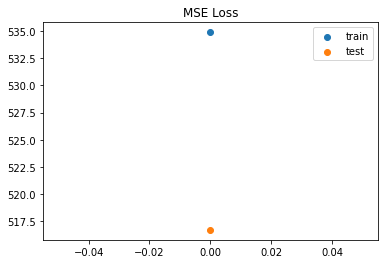

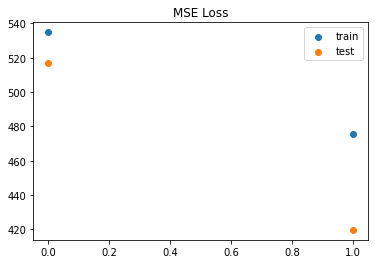

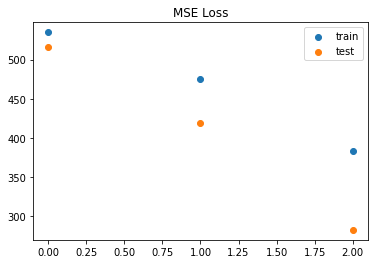

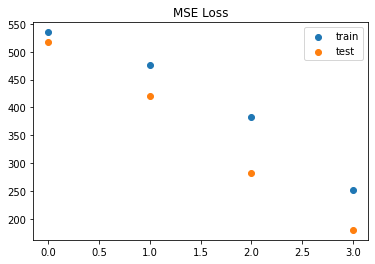

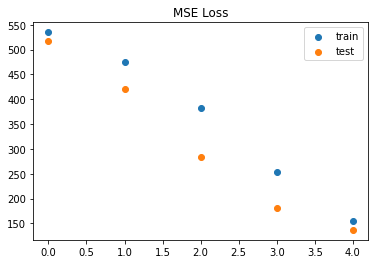

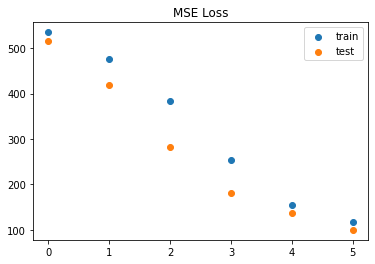

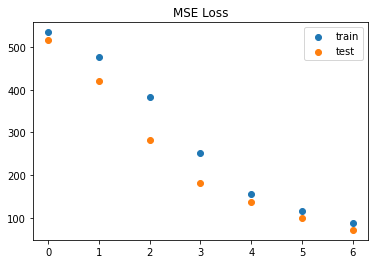

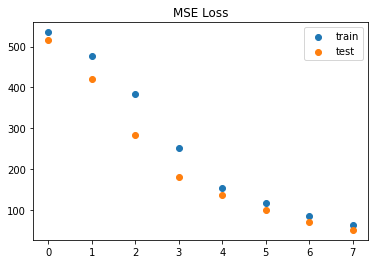

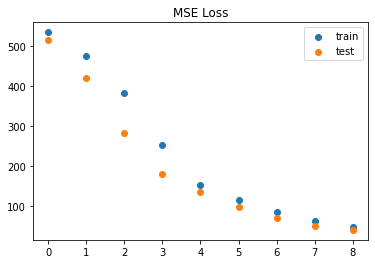

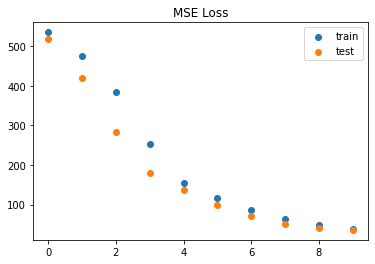

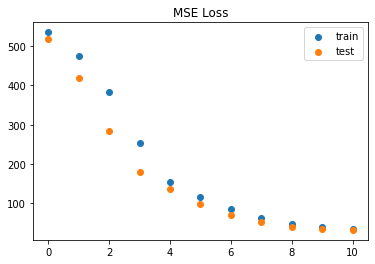

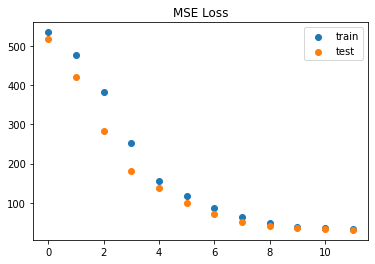

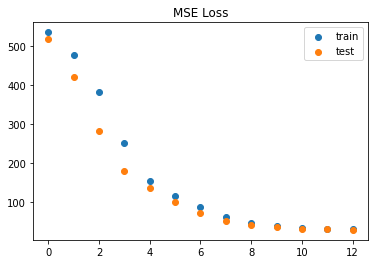

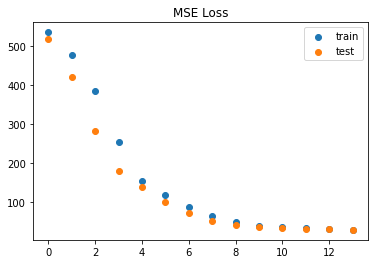

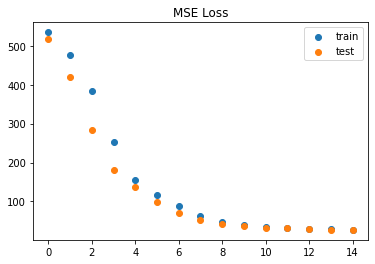

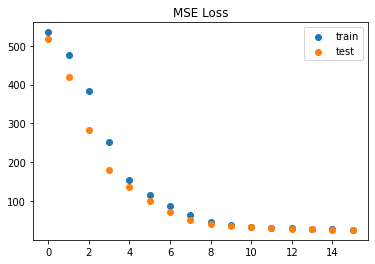

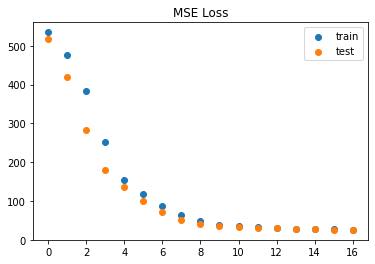

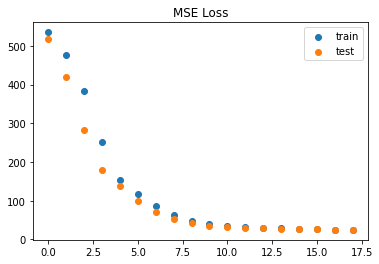

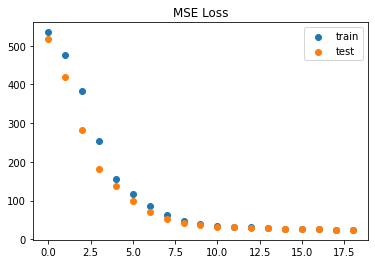

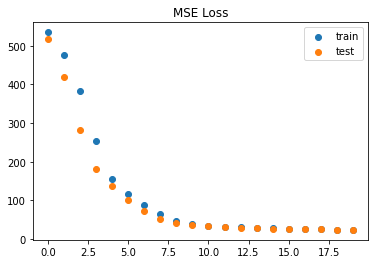

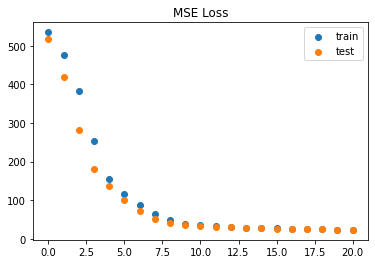

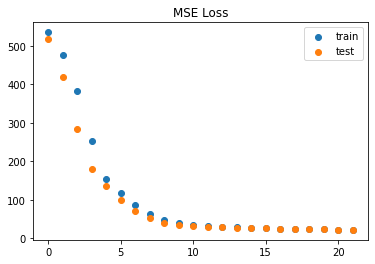

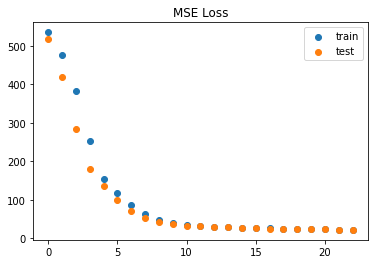

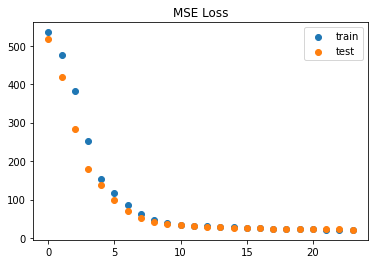

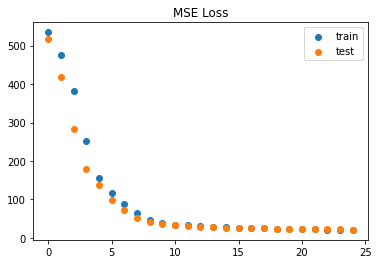

In [65]:
NUM_EPOCH = 25
train_loss_history, test_loss_history = [], []

for epoch_num in range(NUM_EPOCH):
    opt.zero_grad()
    
    y_predicted = model(X_train_torch)
    loss = loss_function(y_predicted, y_train_torch)
    loss.backward()
    opt.step()
    
    train_loss_history.append(loss.item()) # Always use .item() to store scalars in logs!
    
    with torch.no_grad():
        y_predicted_test = model(X_test_torch)
        test_loss_history.append(loss_function(y_predicted_test, y_test_torch).item())
    # the rest of code is just bells and whistles

    #clear_output(True)
    plt.scatter(np.arange(len(train_loss_history)), train_loss_history, label='train')
    plt.scatter(np.arange(len(test_loss_history)), test_loss_history, label='test')
    plt.title('MSE Loss')
    plt.legend()
    plt.show()


In [66]:
print('Final NN MSE on train data: {:.3f}'.format(train_loss_history[-1]))
print('Final NN MSE on test data: {:.3f}'.format(test_loss_history[-1]))

Final NN MSE on train data: 20.691
Final NN MSE on test data: 21.594


### Потребление памяти различными алгоритмами

In [67]:
import torch
import torchvision
import numpy as np
from torch import nn
import torch.autograd.profiler as profiler

In [68]:
N_FEATURES_BIG = 500
HID_SIZE = 512

#В этот раз сгенерируем случайную выборку достаточно большого размера:

X_train_torch = torch.randn((1000, N_FEATURES_BIG))
y_train_torch = torch.randn((1000, 1))

Следующая функция воспроизводит классический цикл из создания модели, инициализации оптимизатора и непосредственного обучения, но также логгирует различные параметры (потребление памяти, количество вызовов и др.) автоматически.

In [73]:
N_FEATURES_SMALL = 2
N_CLASSES_SMALL = 3
NUM_EPOCH = 50000

def create_model(activation, hid_size=50, num_features=N_FEATURES_SMALL, n_out=N_CLASSES_SMALL):
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(num_features, hid_size))
    model.add_module('activation1', activation())
    model.add_module('l2', nn.Linear(hid_size, hid_size))
    model.add_module('activation2', activation())
    model.add_module('l3', nn.Linear(hid_size, n_out))

    return model



def profile_model(activation, optimizer, X_train_torch=X_train_torch, y_train_torch=y_train_torch):
    model = create_model(
        activation,
        hid_size=HID_SIZE,
        num_features=N_FEATURES_BIG,
        n_out=1)
    loss_function = nn.MSELoss()

    opt = optimizer(model.parameters(), lr=0.01)

    # warm-up
    model(X_train_torch)

    out = model(X_train_torch)
    loss = loss_function(out, y_train_torch)
    loss.backward()
    with profiler.profile(profile_memory=True) as prof:
        opt.step()
    opt.zero_grad()

    return prof

In [ ]:
Сравним процесс обучения с помощью различных оптимизаторов:

In [74]:
prof = profile_model(nn.ReLU, torch.optim.SGD)
print(prof.key_averages(group_by_stack_n=5).table(sort_by='cpu_memory_usage', row_limit=15))

---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                       Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                aten::empty         5.88%      63.000us         5.88%      63.000us      31.500us         372 b         372 b             2  
                aten::zeros         2.05%      22.000us         7.00%      75.000us      75.000us           4 b           0 b             1  
                aten::zero_         0.09%       1.000us         0.09%       1.000us       1.000us           0 b           0 b             1  
                 aten::add_        32.00%     343.000us        32.00%     343.000us      57.167us           0 b           0 b             6  
    Op

In [75]:
prof = profile_model(nn.ReLU, torch.optim.Adam)
print(prof.key_averages(group_by_stack_n=15).table(sort_by='cpu_memory_usage', row_limit=15))

----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                        Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
----------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
         aten::empty_strided         3.12%     326.000us         3.12%     326.000us       9.056us       3.96 Mb       3.96 Mb            36  
            aten::zeros_like         0.37%      39.000us         5.51%     575.000us      47.917us       3.96 Mb           0 b            12  
            aten::empty_like         0.26%      27.000us         1.31%     137.000us      11.417us       3.96 Mb           0 b            12  
    Optimizer.step#Adam.step        21.11%       2.204ms        99.70%      10.411ms      10.411ms       3.96 Mb      -3.97 Mb             1  

In [76]:
prof = profile_model(nn.ReLU, torch.optim.RMSprop)
print(prof.key_averages(group_by_stack_n=15).table(sort_by='cpu_memory_usage', row_limit=15))

-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                           Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
            aten::empty_strided         4.74%     186.000us         4.74%     186.000us      10.333us       1.98 Mb       1.98 Mb            18  
               aten::zeros_like         0.43%      17.000us         6.65%     261.000us      43.500us       1.98 Mb           0 b             6  
               aten::empty_like         0.43%      17.000us         1.96%      77.000us      12.833us       1.98 Mb           0 b             6  
                     aten::sqrt        11.16%     438.000us        11.16%     438.000us      73.000us       1.98 Mb       1.